Numerical Evaluation of Integrals
====

Quadrature
----

You may recall from Calculus that integrals can be numerically evaluated using quadrature methods such as Trapezoid and Simpson's's rules. This is easy to do in Python, but has the drawback of the complexity growing as $O(n^d)$ where $d$ is the dimensionality of the data, and hence infeasible once $d$ grows beyond a modest number.

### Integrating functions

In [1]:
from scipy.integrate import quad

In [2]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

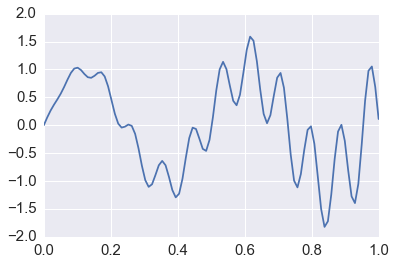

In [3]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Exact solution

In [4]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6)

0.0202549

#### Using quadrature

In [5]:
y, err = quad(f, 0, 1.0)
y

0.02025493910239419

#### Multiple integration

Following the `scipy.integrate` [documentation](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html), we integrate

$$
I=\int_{y=0}^{1/2}\int_{x=0}^{1-2y} x y \, dx\, dy
$$

In [6]:
x, y = symbols('x y')
integrate(x*y, (x, 0, 1-2*y), (y, 0, 0.5))

0.0104166666666667

In [7]:
from scipy.integrate import nquad

def f(x, y):
    return x*y

def bounds_y():
    return [0, 0.5]

def bounds_x(y):
    return [0, 1-2*y]

y, err = nquad(f, [bounds_x, bounds_y])
y

0.010416666666666668

Monte Carlo integration
----

The basic idea of Monte Carlo integration is very simple and only requires elementary statistics. Suppose we want to find the value of 
$$
\int_a^b f(x) dx
$$
in some region with volume $V$. Monte Carlo integration estimates this integral by estimating the fraction of random points that fall below $f(x)$ multiplied by $V$. 


In a statistical context, we use Monte Carlo integration to estimate the expectation
$$
E[h(X)] = \int_X h(x) f(x) dx
$$

with

$$
\bar{h_n} = \frac{1}{n} \sum_{i=1}^n h(x_i)
$$
where $x_i \sim f$ is a draw from the density $f$.

We can estimate the Monte Carlo variance of the approximation as
$$
v_n = \frac{1}{n^2} \sum_{o=1}^n (h(x_i) - \bar{h_n})^2)
$$

Also, from the Central Limit Theorem,

$$
\frac{\bar{h_n} - E[h(X)]}{\sqrt{v_n}} \sim \mathcal{N}(0, 1)
$$

The convergence of Monte Carlo integration is $\mathcal{0}(n^{1/2})$ and independent of the dimensionality. Hence Monte Carlo integration generally beats numerical integration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $\mathcal{0}(n^{d})$. Even for low dimensional problems, Monte Carlo integration may have an advantage when the volume to be integrated is concentrated in a very small region and we can use information from the distribution to draw samples more often in the region of importance.

### Example

We want to estimate the following integral $\int_0^1 e^x dx$. The minimum value of the function is 1 at $x=0$ and $e$ at $x=1$.

x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= np.e
plt.scatter(pts[:, 0], pts[:, 1])
plt.xlim([0,1])
plt.ylim([0, np.e])
pass

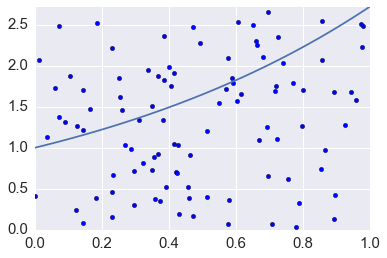

In [8]:
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= np.e
plt.scatter(pts[:, 0], pts[:, 1])
plt.xlim([0,1])
plt.ylim([0, np.e])
pass

#### Analytic solution

In [9]:
from sympy import symbols, integrate, exp

x = symbols('x')
expr = integrate(exp(x), (x,0,1))
expr.evalf()

1.71828182845905

#### Using quadrature

In [10]:
from scipy import integrate

y, err = integrate.quad(exp, 0, 1)
y

1.7182818284590453

#### Monte Carlo integration

In [11]:
for n in 10**np.array([1,2,3,4,5,6,7,8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= np.e
    count = np.sum(pts[:, 1] < np.exp(pts[:, 0]))
    volume = np.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

        10 1.902797
       100 1.658152
      1000 1.731546
     10000 1.716595
    100000 1.715508
   1000000 1.719207
  10000000 1.718699
 100000000 1.718137


### Monitoring variance in Monte Carlo integration

We are often interested in knowing how many iterations it takes for Monte Carlo integration to "converge". To do this, we would like some estimate of the variance, and it is useful to inspect such plots. One simple way to get confidence intervals for the plot of Monte Carlo estimate against number of iterations is simply to do many such simulations.

For the example, we will try to estimate the function (again)

$$
f(x) = x \cos 7x + \sin 13x, \ \  0 \le x \le 1
$$

In [12]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

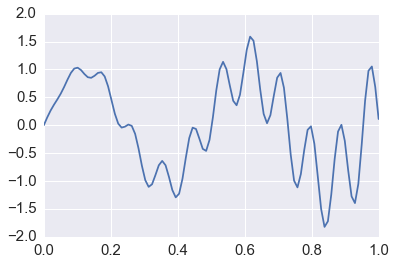

In [13]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Single MC integration estimate

In [14]:
n = 100
x = f(np.random.random(n))
y = 1.0/n * np.sum(x)
y

0.094883119956087489

#### Using multiple independent sequences to monitor convergence

In [15]:
n = 100
reps = 1000

x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:, None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [2.5, 97.5], axis=1)

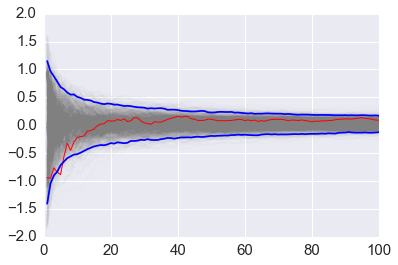

In [16]:
plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

#### Using bootstrap to monitor convergence

In [17]:
xb = np.random.choice(x[:,0], (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

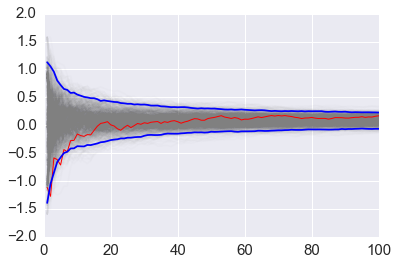

In [18]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

Variance Reduction
----

### Change of variables

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty \lt x \lt \infty 
$$

Suppose we want to integrate the tail probability $P(X > 3)$ using Monte Carlo

In [19]:
import scipy.stats as stats

h_true = 1 - stats.cauchy().cdf(3)
h_true

0.10241638234956674

In [20]:
n = 100

x = stats.cauchy().rvs(n)
h_mc = 1.0/n * np.sum(x > 3)
h_mc, np.abs(h_mc - h_true)/h_true

(0.16, 0.56225006516915765)

We are trying to estimate the quantity

$$
\int_3^\infty \frac{1}{\pi (1 + x^2)} dx
$$

Using the substitution $y = 3/x$ (and a little algebra), we get

$$
\int_0^1 \frac{3}{\pi(9 + y^2)} dy
$$

Hence, a much more efficient MC estimator is 

$$
\frac{1}{n} \sum_{i=1}^n \frac{3}{\pi(9 + y_i^2)}
$$

where $y_i \sim \mathcal{U}(0, 1)$.

In [21]:
y = stats.uniform().rvs(n)
h_cv = 1.0/n * np.sum(3.0/(np.pi * (9 + y**2)))
h_cv, np.abs(h_cv - h_true)/h_true

(0.10202273260522265, 0.0038436208672210301)

### Monte Carlo swindles 

Apart from change of variables, there are several general techniques for variance reduction, sometimes known as Monte Carlo swindles since these methods improve the accuracy and convergence rate of Monte Carlo integration without increasing the number of Monte Carlo samples. Some Monte Carlo swindles are:

- importance sampling
- stratified sampling
- control variates
- antithetic variates
- conditioning swindles including Rao-Blackwellization and independent variance decomposition

Most of these techniques are not particularly computational in nature, so we will not cover them in the course. I expect you will learn them elsewhere. We will illustrate importance sampling and antithetic variables here as examples.

### Importance sampling

Basic Monte Carlo sampling evaluates

$$
E[h(X)] = \int_X h(x) f(x) dx
$$

Using another distribution $g(x)$ - the so-called "importance function", we can rewrite the above expression

$$
E_f[h(x)] \ = \  \int_X h(x) \frac{f(x)}{g(x)} g(x) dx \ = \ E_g\left[ \frac{h(X) f(X)}{g(X)} \right]
$$

giving us the new estimator

$$
\bar{h_n} = \frac{1}{n} \sum_{i=1}^n \frac{f(x_i)}{g(x_i)} h(x_i)
$$

where $x_i \sim g$ is a draw from the density $g$.

Conceptually, what the likelihood ratio $f(x_i)/g(x_i)$ provides an indicator of how "important" the sample $h(x_i)$ is for estimating $\bar{h_n}$. This is very dependent on a good choice for the importance function $g$. Two simple choices for $g$ are scaling

$$
g(x) = \frac{1}{a} f(x/a)
$$

and translation

$$
g(x) = f(x - a)
$$

Alternatively, a different distribution can be chosen as shown in the example below.

#### Example

Suppose we want to estimate the tail probability of $\mathcal{N}(0, 1)$ for $P(X > 5)$. Regular MC integration using samples from $\mathcal{N}(0, 1)$ is hopeless since nearly all samples will be rejected. However, we can use the exponential density truncated at 5 as the importance function and use importance sampling.

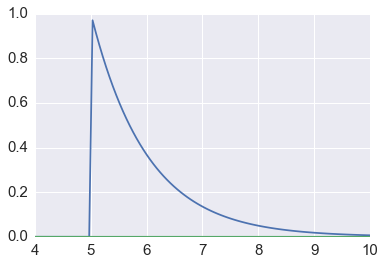

In [22]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))
plt.plot(x, stats.norm().pdf(x))
pass

#### Expected answer

We expect about 3 draws out of 10,000,000 from $\mathcal{N}(0, 1)$ to have a value greater than 5. Hence simply sampling from $\mathcal{N}(0, 1)$ is hopelessly inefficient for Monte Carlo integration.

In [23]:
%precision 10

'%.10f'

In [24]:
h_true =1 - stats.norm().cdf(5)
h_true

0.0000002867

#### Using direct Monte Carlo integration

In [25]:
n = 10000
y = stats.norm().rvs(n)
h_mc = 1.0/n * np.sum(y > 5)
# estimate and relative error
h_mc, np.abs(h_mc - h_true)/h_true 

(0.0000000000, 1.0000000000)

#### Using importance sampling

In [26]:
n = 10000
y = stats.expon(loc=5).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y))
# estimate and relative error
h_is, np.abs(h_is- h_true)/h_true

(0.0000002841, 0.0088200435)

### Antithetic variables

The idea behind antithetic variables is to choose two sets of random numbers that are negatively correlated, then take their average, so that the total variance of the estimator is smaller than it would be with two sets of IID random variables.

In [27]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

In [28]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
sol = integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(16)
sol

0.02025493910239406

In [29]:
n = 10000
u = np.random.random(n)
x = f(u)
y = 1.0/n * np.sum(x)
y, abs(y-sol)/sol

(0.0230464194, 0.1378172660206196)

#### Antithetic variables use first half of `u`  supplemented with `1-u`

In [30]:
u = np.r_[u[:n//2], 1-u[:n//2]]
x = f(u)
y = 1.0/n * np.sum(x)
y, abs(y-sol)/sol

(0.0268858498, 0.3273725341840888)

Quasi-random numbers
----

Recall that the convergence of Monte Carlo integration is $\mathcal{0}(n^{1/2})$. It turns out that if we use quasi-random or low discrepancy sequences (which fill space more efficiently than random sequences), we can get convergence approaching $\mathcal{0}(1/n)$. There are several such generators, but their use in statistical settings is limited to cases where we are integrating with respect to uniform distributions. The regularity can also give rise to errors when estimating integrals of periodic functions. However, these quasi-Monte Carlo methods are used in computational finance models.

Run 
```
! pip install ghalton
```
if `ghalton` is not installed.

In [31]:
import ghalton

gen = ghalton.Halton(2)

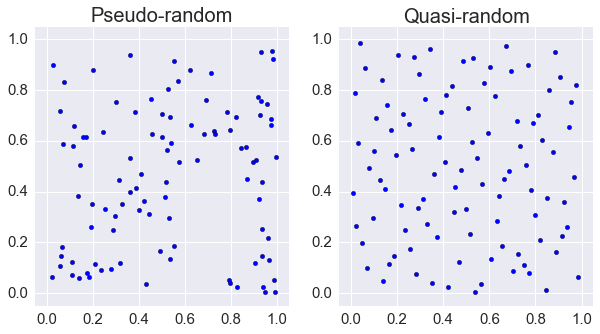

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(121)
xs = np.random.random((100,2))
plt.scatter(xs[:, 0], xs[:,1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('Pseudo-random', fontsize=20)
plt.subplot(122)
ys = np.array(gen.get(100))
plt.scatter(ys[:, 0], ys[:,1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('Quasi-random', fontsize=20);

#### Quasi-Monte Carlo integration can reduce variance

In [33]:
h_true = 1 - stats.cauchy().cdf(3)

In [36]:
n = 10
x = stats.uniform().rvs((n, 5))
y = 3.0/(np.pi * (9 + x**2))
h_mc = np.sum(y, 0)/n
list(zip(h_mc, 100*np.abs(h_mc - h_true)/h_true))

[(0.1020030639, 0.4035666902),
 (0.1011716917, 1.2153237752),
 (0.1029823526, 0.5526169416),
 (0.1042195045, 1.7605798453),
 (0.1033874412, 0.9481479851)]

In [37]:
gen1 = ghalton.Halton(1)
x = np.reshape(gen1.get(n*5), (n, 5))
y = 3.0/(np.pi * (9 + x**2))
h_qmc = np.sum(y, 0)/n
list(zip(h_qmc, 100*np.abs(h_qmc - h_true)/h_true))

[(0.1026632536, 0.2410466633),
 (0.1023042949, 0.1094428682),
 (0.1026741252, 0.2516617574),
 (0.1029118212, 0.4837496311),
 (0.1026111501, 0.1901724534)]